# XGBoost
## Daten einlesen

In [1]:
import os

import pandas as pd

from src.dataPipeline import DataPipeline

os.chdir('..')

In [2]:
from sklearn.impute import SimpleImputer, KNNImputer
import numpy as np

imputer = KNNImputer(n_neighbors=10)
#imputer = SimpleImputer(strategy='constant', fill_value=None)

dp = DataPipeline()
df = dp.runPipeline(normalizeAndStandardize=True, imputer=imputer, basic_house_imputer=True)
#df_kaggle = dp.prepare_kaggle_dataset(filePath='./data/test_data-Kaggle-v0.11.csv', normalizeAndStandardize=True, imputer=imputer, basic_house_imputer=True)

C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:45: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,49,50,107,110,114,115,116,119,120,121,124,125,126,128,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(filePath)
C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:72: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ]].bfill(axis=1)['Space extracted']
C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:77: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To o

In [3]:
#from src.utils.helperFunctions import pickle_dataframe, unpickle_dataframe

#pickle_dataframe(df, 'df.pkl')
#pickle_dataframe(df_kaggle, 'df_kaggle.pkl')


In [4]:
#from src.utils.helperFunctions import pickle_dataframe, unpickle_dataframe

#df = unpickle_dataframe('df.pkl')
#df_kaggle = unpickle_dataframe('df_kaggle.pkl')

## Modell erstellen


In [6]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

y = df['price_cleaned']
y_log = np.log(y)

X = df.drop(columns=['price_cleaned'])


# Apply PCA
n_components = 20
pca = PCA(n_components=n_components)
#X = pca.fit_transform(X)


train_test_split_ratio = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=train_test_split_ratio)

model = XGBRegressor(objective='reg:absoluteerror', eval_metric='mape', n_estimators=1000, learning_rate=0.005, max_depth=9, reg_lambda=1.5, reg_alpha=8, grow_policy='depthwise', min_split_loss=5, min_child_weight=20, subsample=0.9, max_bin=2048, booster='gbtree', max_delta_step=3,
                     colsample_bylevel=0.8, colsample_bytree=0.8, colsample_bynode=0.8, tree_method='hist', verbosity=1, n_jobs=-1)

weights = np.where(
    y_train < np.log(50000), 50.0,
        np.where(y_train < np.log(100000), 40.0,
            np.where(y_train < np.log(200000), 20.0,
                np.where(y_train < np.log(1200000), 2.0, 1.0)
            )
        )
)
model.fit(X_train, y_train, sample_weight=weights)
y_pred = model.predict(X_test)

y_test = np.exp(y_test)
y_pred = np.exp(y_pred)

mape_test = mean_absolute_percentage_error(y_test, y_pred) * 100
r2 = model.score(X_test, y_test)

print(f'Test MAPE: {mape_test:.3f}%, R2: {r2:.3f}')

# Train Mape
y_pred = model.predict(X_train)
y_train = np.exp(y_train)
y_pred = np.exp(y_pred)

mape_train = mean_absolute_percentage_error(y_train, y_pred) * 100
r2 = model.score(X_train, y_train)

print(f'Train MAPE: {mape_train:.3f}%, R2: {r2:.3f}')

Test MAPE: 27.381%, R2: -0.654
Train MAPE: 22.027%, R2: -0.570


In [11]:
#from src.utils.helperFunctions import create_kaggle_results

#results = model.predict(df_kaggle)
#results = np.exp(results)
#create_kaggle_results(results, csv_name='xgBoost_pipeline_5000')

File xgBoost_pipeline_5000_2025-01-01_18-08-41.csv created successfully.


C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\utils\helperFunctions.py:13: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,48,49,104,111,112,115,116,117,120,121,122,124,127,128,130,131) have mixed types. Specify dtype option on import or set low_memory=False.
  indexes = pd.read_csv(path_to_kaggledata)['Unnamed: 0']


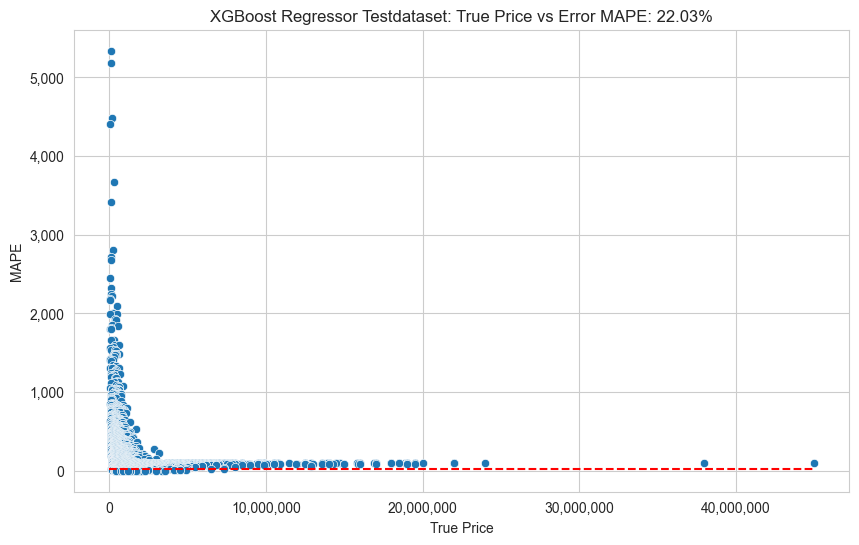

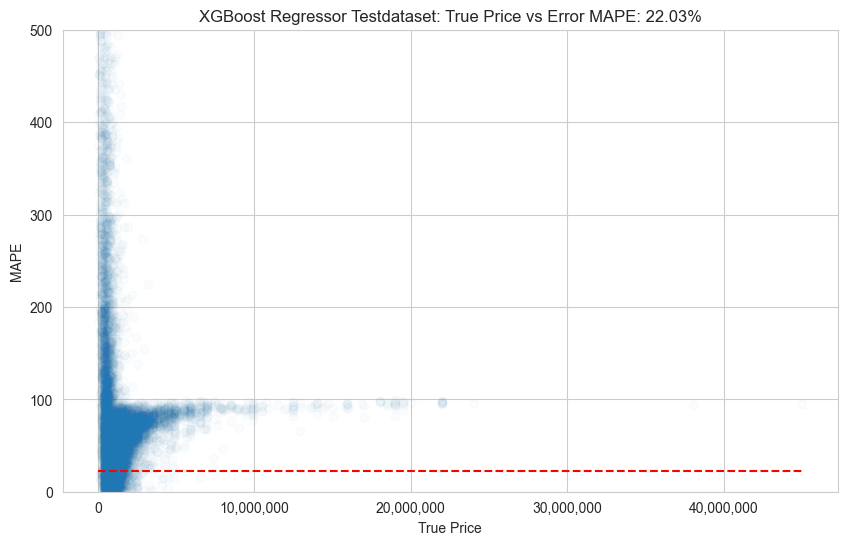

In [11]:
from src.utils.helperFunctions import analyse_highest_errors
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = np.exp(model.predict(X_train))
mape = mean_absolute_percentage_error(y_train, y_pred) * 100
error_analysis = analyse_highest_errors(y_train, y_pred, X_train, dp)
error_analysis
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 6))
sns.scatterplot(x=error_analysis['true_price'], y=error_analysis['mape'])
plt.xlabel('True Price')
plt.ylabel('MAPE')
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format x-axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format y-axis
plt.title(f'XGBoost Regressor Testdataset: True Price vs Error MAPE: {mape:.2f}%')
plt.hlines(y=mape, xmin=0, xmax=error_analysis['true_price'].max(), color='red',
           linestyles='dashed')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(x=error_analysis['true_price'], y=error_analysis['mape'], alpha=0.02)
plt.xlabel('True Price')
plt.ylabel('MAPE')
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format x-axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format y-axis
plt.ylim(0, 500)
plt.title(f'XGBoost Regressor Testdataset: True Price vs Error MAPE: {mape:.2f}%')

plt.hlines(y=mape, xmin=0, xmax=error_analysis['true_price'].max(), color='red',
           linestyles='dashed')
plt.show()

In [12]:
error_analysis

,Floor,gde_pop_per_km2,Space extracted,plz_parsed,Plot_area_unified,No. of rooms:,Last refurbishment:,Year built:,Number of floors:,type_unified_attic-room,...,region_group_44,region_group_45,region_group_46,region_group_47,region_group_48,region_group_49,true_price,predicted_price,error,mape
7437,4.00,2074.77,900.00,1802.00,2500.00,33.00,2000.00,1980.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,120000.00,6526594.00,6406594.00,5338.83
1704,4.00,804.90,668.00,1052.00,2537.00,10.00,2012.00,1733.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,100000.00,5284605.50,5184605.50,5184.61
7033,0.00,1318.14,400.00,1245.00,1404.00,8.00,2013.00,2013.00,2.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,145000.00,6638147.50,6493147.50,4478.03
10462,1.00,211.16,99.00,1522.00,0.00,3.50,2013.00,2013.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,13480.00,607509.75,594029.75,4406.75
12329,0.00,1318.14,1300.00,1222.00,6800.00,20.00,1996.20,1968.90,4.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,280000.00,10558819.00,10278819.00,3671.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16485,1.00,395.36,75.00,6644.00,0.00,5.00,2014.00,2005.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,539374.25,NaN,NaN
16488,2.00,1261.62,120.00,1291.00,0.00,3.00,2003.90,1988.90,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,1286880.75,NaN,NaN
16491,0.00,224.66,642.00,1854.00,2767.00,8.75,2021.00,1930.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,2935318.00,NaN,NaN
16493,0.00,84.52,170.00,1426.00,756.00,6.00,1982.10,1955.20,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,1034598.00,NaN,NaN


In [13]:
# make list with feature names

feature_importances = pd.DataFrame()
feature_importances['feature'] = model.feature_names_in_
feature_importances['importance'] = model.feature_importances_
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,feature,importance
2,Space extracted,0.05
44,region_group_16,0.04
5,No. of rooms:,0.03
47,region_group_19,0.03
26,type_unified_studio,0.02
...,...,...
48,region_group_20,0.00
56,region_group_28,0.00
38,region_group_10,0.00
21,type_unified_secondary-suite,0.00


# Grid Search

In [5]:
#from src.utils.helperFunctions import pickle_dataframe, unpickle_dataframe

#df = unpickle_dataframe('df_without_imputer.pkl')
#df_kaggle = unpickle_dataframe('df_kaggle_without_imputer.pkl')

DataFrame loaded from df_without_imputer.pkl.
DataFrame loaded from df_kaggle_without_imputer.pkl.


In [13]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# Assuming df is your DataFrame
# y = df['price_cleaned']
# y_log = np.log(y)
# X = df.drop(columns=['price_cleaned'])

# For testing purposes
# df = pd.read_csv("your_dataset.csv")
y = df['price_cleaned']
y_log = np.log(y)
X = df.drop(columns=['price_cleaned'])

# Split data into training and testing sets
train_test_split_ratio = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=train_test_split_ratio)

# Define the XGBRegressor model
xgb = XGBRegressor(objective='reg:absoluteerror')

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': np.linspace(200, 800, 4, dtype=int),
    'learning_rate': [0.01],
    'max_depth': [7, 9, 11],
    'reg_lambda': [1],
    'reg_alpha': [4, 5],
    'grow_policy': ['depthwise'],
    'min_split_loss': [4, 5],
    'min_child_weight': [10, 15, 20],
    'subsample': [0.8, 0.9, 0.95],
    'max_bin': [2048],
    'booster': ['gbtree'],
    'max_delta_step': [2],
    'colsample_bylevel': [0.8],
    'colsample_bytree': [0.8],
    'colsample_bynode': [0.8],
    'tree_method': ['hist'],
    'verbosity': [1],
}

# Use MAPE as the scoring metric
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=mape_scorer,
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

# Retrieve the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
y_test = np.exp(y_test)
y_pred = np.exp(y_pred)

test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f'Test MAPE with Best Model: {test_mape:.3f}%')

# Evaluate the best model on the training set
y_pred_train = best_model.predict(X_train)
y_train = np.exp(y_train)
y_pred_train = np.exp(y_pred_train)

train_mape = mean_absolute_percentage_error(y_train, y_pred_train) * 100
print(f'Train MAPE with Best Model: {train_mape:.3f}%')

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


C:\FHNW_Programmiersachen\5_Sem\immo_challenge\.venv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bynode': 0.8, 'colsample_bytree': 0.8, 'grow_policy': 'depthwise', 'learning_rate': 0.01, 'max_bin': 2048, 'max_delta_step': 2, 'max_depth': 11, 'min_child_weight': 10, 'min_split_loss': 4, 'n_estimators': 800, 'reg_alpha': 4, 'reg_lambda': 1, 'subsample': 0.9, 'tree_method': 'hist', 'verbosity': 1}
Test MAPE with Best Model: 27.663%
Train MAPE with Best Model: 19.643%
